# Análisis de cada Carrera

Ejemplo de simulación de una estación de servicio

Para realizar un análisis de los datos del DataFrame resultante, puedes realizar varias operaciones utilizando las funciones y métodos proporcionados por la biblioteca Pandas en Python. Aquí hay algunas sugerencias sobre cómo podrías analizar los datos:

In [174]:
import matplotlib.pyplot as plt
import pandas as pd

In [175]:
df_pits = pd.read_csv('./pitstops.csv')
df_classific = pd.read_csv('./race_classification.csv')
df_lap_times = pd.read_csv('./lap_times.csv')
df_chrases = pd.read_csv('./chrases.csv')

In [176]:
# En los dataframe que contienen un diccionario como string, queremos "extraer" esto de forma segura para poder trabajar con ello
# Función para convertir el string a diccionario usando eval() de manera segura
def safe_eval(string):
    try:
        # Evaluar solo si el string es similar a un diccionario
        if string.startswith('{') and string.endswith('}'):
            return eval(string, {"__builtins__": {}}, {})
    except:
        return {}

# Aplicar la conversión segura
df_chrases['Compound'] = df_chrases['Compound'].apply(safe_eval)
df_pits['Compound Type'] = df_pits['Compound Type'].apply(safe_eval) 

# "Rellenamos" los None que representa el rainType para que indique que no hay lluvia en dichos casos
df_chrases.fillna({'Rain':'No Rain'}, inplace=True)
df_pits.fillna({'Type Rain':'No Rain'}, inplace=True)

# Filter the DB to skip the pitstop times that equal zero (this happens when vehicles are initialized and at the finish of the race)
df_pits = df_pits[df_pits['PitStop Time'] != 0]

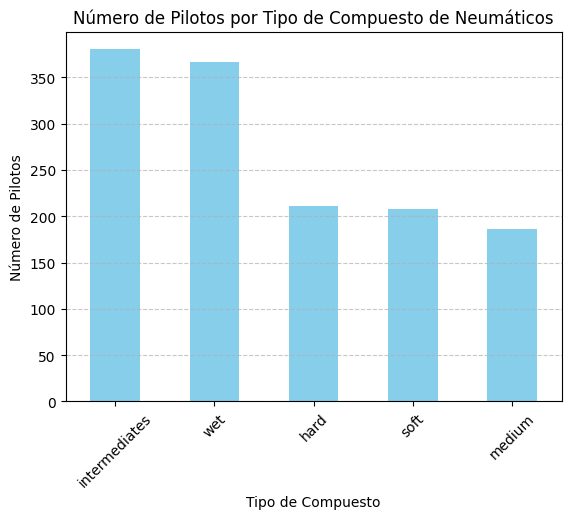

In [177]:
# Contar el número de pilotos por cada tipo de compuesto
compound_counts = df_pits['Compound Type'].apply(lambda x: list(x.keys())[0]).value_counts()
compound_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Pilotos por Tipo de Compuesto de Neumáticos')
plt.xlabel('Tipo de Compuesto')
plt.ylabel('Número de Pilotos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

En la gráfica anterior podemos observar que la estrategia seguida para los tipos de neumáticos disponibles en condiciones de seco (hard, medium y soft) están bastante equilibradas, quedadno esta elección a las estrategias que acabe siguiendo cada uno. Sin embargo, cuando miramos los compuestos wet e intermediates, siempre que se están dando condiciones de lluvia durante el campeonato, todos los vehículos acaban escogiendo entre esos compuestos. Notando así que al final hay casi un 40% de vehículos que han acabdo usando el tipo wet por encima de los compuestos para condiciones secas (esto cambiará dependiendo de la lluvia que haya podido haber a lo largo de todo el campeonato).

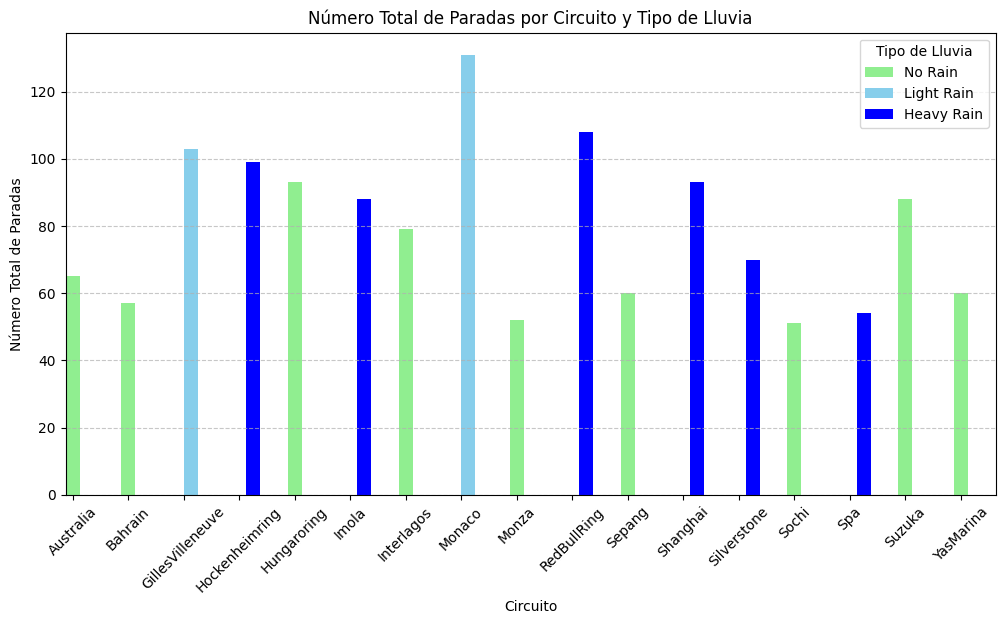

In [178]:
stops_by_circuit_and_rain = df_pits.groupby(['Circuit', 'Type Rain']).size().unstack(fill_value=0)

# Visualización
plt.figure(figsize=(12, 6))

# Gráfico para 'No Rain'
stops_by_circuit_and_rain['No Rain'].plot(kind='bar', color='lightgreen', position=0.5, width=0.25, label='No Rain')

# Gráfico para 'Light Rain'
stops_by_circuit_and_rain['Light Rain'].plot(kind='bar', color='skyblue', position=0, width=0.25, label='Light Rain')

# Gráfico para 'Heavy Rain'
stops_by_circuit_and_rain['Heavy Rain'].plot(kind='bar', color='blue', position=-0.5, width=0.25, label='Heavy Rain')

plt.title('Número Total de Paradas por Circuito y Tipo de Lluvia')
plt.xlabel('Circuito')
plt.ylabel('Número Total de Paradas')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Lluvia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

En el anterior gráfico se puede apreciar cómo los pilotos se ven obligados a parar más en condiciones de lluvia generalmente. Sin embarrgo, hay diferencias significativas por el número de vueltas de cada circuito. Para ello haremos el siguiente gráfico donde se ve el número total de vueltas para cada circuito.

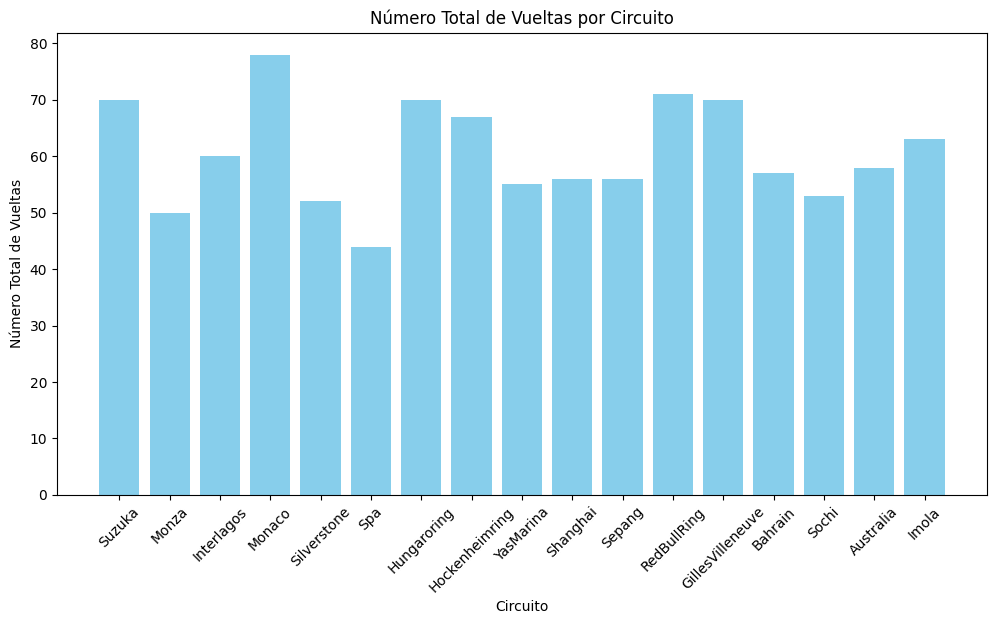

In [179]:
plt.figure(figsize=(12, 6))

# Gráfico de barras para el número total de vueltas por circuito
plt.bar(df_pits['Circuit'], df_pits['Track Laps'], color='skyblue')

plt.title('Número Total de Vueltas por Circuito')
plt.xlabel('Circuito')
plt.ylabel('Número Total de Vueltas')
plt.xticks(rotation=45)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [180]:
stops_per_circuit = df_pits.groupby('Circuit').size()
# Calcular la correlación entre el número de vueltas por circuito y el total de paradas que se realizan
correlation = df_pits.groupby('Circuit')['Track Laps'].first().corr(stops_per_circuit)
print("Correlación entre el número de vueltas por circuito y el total de paradas:", correlation)

Correlación entre el número de vueltas por circuito y el total de paradas: 0.8903680926315966


Como se ve, la correlación es bastante alta, queriendo decir que están estrechamente relacionadas. Pero no tanto como para obviar el hecho de que sí que se realizan más paradas con condiciones de lluvia que en seco, incluso para circuitos con similar número de vueltas. Esto se debe a que la probabilidad de accidente se v elevada por las propias condiciones de pista y si a esto le sumamos además el "apurar" los neumáticos, sería un riesgo demasiado alto para asumir. 


Además de la condición de que todos los vehículos se ven obligados a parar a cambiar ruedas cuando hay 'heavy rain'; pero esto es algo que no ocurre tan a menudo ni repetidas veces en una misma carrera, y no tiene un impacto significativo para nuestra conclusión final.

In [181]:
pits_before_lap_19 = df_pits[(df_pits['Lap'] <= 19)]

# Imprimir los resultados
print("Paradas realizadas antes de la vuelta 19:")
print(pits_before_lap_19[['Vehicle', 'Compound Type', 'Type Rain', 'Lap']])

Paradas realizadas antes de la vuelta 19:
        Vehicle          Compound Type   Type Rain  Lap
569    Vehicle8  {'intermediates': 27}  Light Rain   19
570    Vehicle7            {'wet': 29}  Light Rain   19
802   Vehicle49  {'intermediates': 20}  Heavy Rain   19
971   Vehicle37  {'intermediates': 28}  Heavy Rain   19
972   Vehicle11  {'intermediates': 29}  Heavy Rain   19
1318  Vehicle12  {'intermediates': 22}  Heavy Rain   19
2029  Vehicle42  {'intermediates': 28}  Heavy Rain   19
2237  Vehicle15  {'intermediates': 28}  Light Rain   19


La tabla anterior es interesante ya que vemos que muy pocos pilotos paran "más pronto de lo debido" y, cuando lo hacen, se debe a condiciones de lluvia solamente (excepto puntualidades muy concretas). Hemos elegido el número de vuelta 19 ya que es el mínimo recomendado posible para cualquier tipo de compuesto, y así evitar cualquier parada interpretada como temprana debido a la duración corta de un compuesto.

In [182]:
summary_stats = df_pits.groupby('Vehicle')['PitStop Time'].mean().round(2)
print(summary_stats)

Vehicle
Vehicle0     24.27
Vehicle1     24.96
Vehicle10    25.25
Vehicle11    25.85
Vehicle12    24.36
Vehicle13    25.88
Vehicle14    25.17
Vehicle15    25.14
Vehicle16    24.58
Vehicle17    25.38
Vehicle18    25.14
Vehicle19    25.95
Vehicle2     25.40
Vehicle20    25.12
Vehicle21    25.83
Vehicle22    25.89
Vehicle23    25.81
Vehicle24    25.43
Vehicle25    24.48
Vehicle26    24.08
Vehicle27    25.36
Vehicle28    25.60
Vehicle29    25.24
Vehicle3     24.42
Vehicle30    25.08
Vehicle31    23.90
Vehicle32    23.91
Vehicle33    25.63
Vehicle34    26.32
Vehicle35    25.09
Vehicle36    23.51
Vehicle37    24.30
Vehicle38    24.55
Vehicle39    23.74
Vehicle4     25.19
Vehicle40    25.65
Vehicle41    25.83
Vehicle42    25.75
Vehicle43    25.26
Vehicle44    24.03
Vehicle45    25.74
Vehicle46    24.10
Vehicle47    26.84
Vehicle48    25.64
Vehicle49    26.17
Vehicle5     24.00
Vehicle6     25.03
Vehicle7     26.43
Vehicle8     25.48
Vehicle9     25.70
Name: PitStop Time, dtype: float64


Podemos observar que el tiempo de pitsop no tiene que ver con ningún factor como el compuesto del neumático o la vuelta en la que se para. Tiene sentido ya que cuesta lo mismo cambiar cualquier tipo de neumáticos y los mecánicos no tienen un "desgaste" como tal para que afecte.

Más pilotos -> Más paradas -> Más similares los tiempos.

## Análisis de distribución de datos

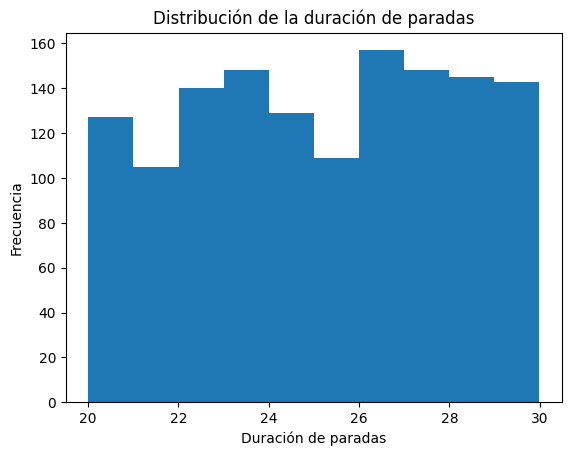

In [183]:
# The following plot shows how the pitstops time distribution
plt.hist(df_pits['PitStop Time'], bins=10)
plt.title('Distribución de la duración de paradas')
plt.xlabel('Duración de paradas')
plt.ylabel('Frecuencia')
plt.show()

En la gráfica anterior podemos apreciar cómo un mayor número de pilotos, hará que la distribución acabe siendo más homogenea que si hubiese un menor número de pilotos (de media). Esto se debe a que la probabilidad de tiempos de parada es igual para todos los vehículos y, por lo tanto, cuantas más interacciones más nos acercaremos a ese ideal.

## Tiempos de vuelta

In [184]:
maximos_por_vuelta = df_lap_times.groupby('Lap')['Lap Time'].max()
minimos_por_vuelta = df_lap_times.groupby('Lap')['Lap Time'].min()

#print('Máximo tiempo por vuelta:', maximos_por_vuelta)
#print('\nMínimo tiempo por vuelta:', minimos_por_vuelta)

La anterior tabla no es para sacar ninguna conclusión per se, solo muestra el menor tiempo de vuelta para cualquier circuito para una vuelta x (y lo mismo para el mayor tiempo de vuelta). 


NOTA: en los tiempos mínimos puede parecer que, cuando el número de vuelta es ya elevado, aumentan mucho el tiempo. Sin embargo, esto se debe a que pocos circuitos tienen números de vuelta por encima de las 74; siendo esos datos no transferibles para nuestro análisis anterior ya que no compara todos los circuitos.

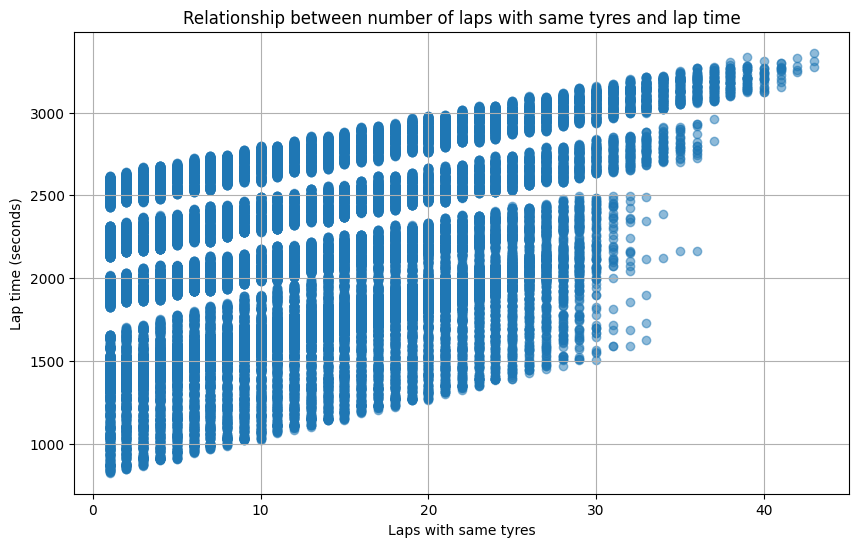

In [185]:
# Arregla la notación con la que está el 'lap time' en el csv para poder usar los datos
def convert_time(time_str):
    time = eval(time_str)
    minutes = time[2]
    seconds = time[4]
    centiseconds = time[6]
    total_time = minutes * 60 + seconds + centiseconds / 100
    return total_time

df_lap_times['Lap Time'] = df_lap_times['Lap Time'].apply(convert_time)

# Gráfica del tiempo por vuelta vs el número de vueltas con los mismos neumáticos
plt.figure(figsize=(10, 6))
plt.scatter(df_lap_times['Compound laps'], df_lap_times['Lap Time'], alpha=0.5)
plt.title('Relationship between number of laps with same tyres and lap time')
plt.xlabel('Laps with same tyres')
plt.ylabel('Lap time (seconds)')
plt.grid(True)
plt.show()

Este gráfico de dispersión indica de forma clara que, a mayor número de vueltas con los mismos compuestos, mayor es el tiempo de vuelta. Esto es muy relevante a la hora de elegir la mejor estrategia para parar, ya que, sin siquiera tomar en consideración la probabilidad de accidentes progresivamente mayor, nos penalizará cuantas más vueltas llevemos con el mismo compuesto. 

## Accidentes
Aquí analizaremos cuando y por qué ocurren la mayoría de los accidentes (para ello se debe coger una muestra de, como poco, 100 pilotos, ya que así sucederán más y podremos analizar mejor los datos). 

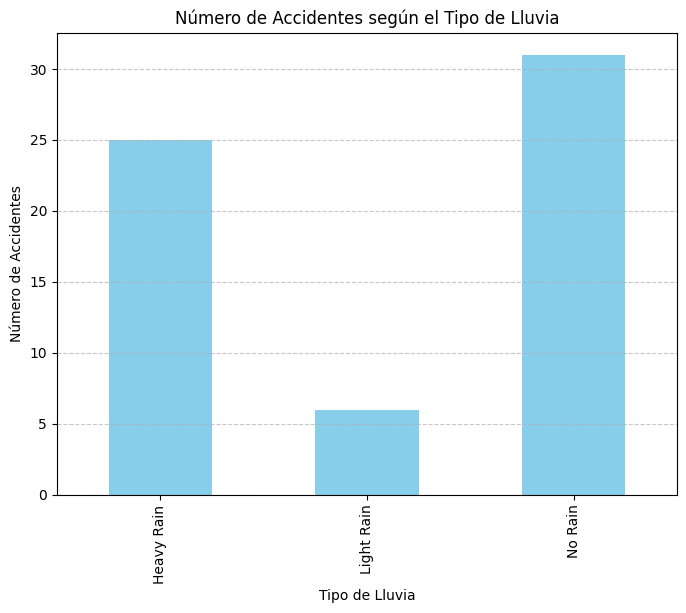

In [186]:
# Contar el número de accidentes para cada tipo de lluvia
accidents_by_rain = df_chrases.groupby('Rain')['Lap'].count()
plt.figure(figsize=(8, 6))
accidents_by_rain.plot(kind='bar', color='skyblue')
plt.title('Número de Accidentes según el Tipo de Lluvia')
plt.xlabel('Tipo de Lluvia')
plt.ylabel('Número de Accidentes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Correlación entre vueltas recomendadas y vueltas completadas con el mismo neumático: 0.31392313958136187


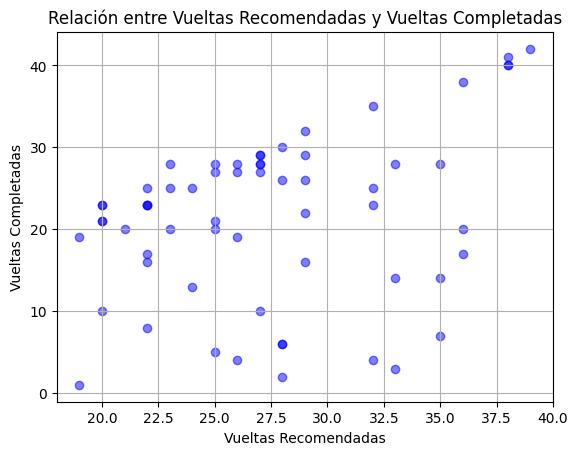

In [187]:
# Suponemos que cada entrada de TireCompound ahora tiene una clave que podemos usar para extraer las vueltas recomendadas
df_chrases['Recommended laps'] = df_chrases['Compound'].apply(lambda x: next(iter(x.values())) if x else None)
# Correlación entre vueltas recomendadas y vueltas completadas
correlation = df_chrases['Recommended laps'].corr(df_chrases['Compound laps completed'])
print("Correlación entre vueltas recomendadas y vueltas completadas con el mismo neumático:", correlation)
plt.scatter(df_chrases['Recommended laps'], df_chrases['Compound laps completed'], alpha=0.5, color='blue')
plt.title('Relación entre Vueltas Recomendadas y Vueltas Completadas')
plt.xlabel('Vueltas Recomendadas')
plt.ylabel('Vueltas Completadas')
plt.grid(True)
plt.show()


Una correlación de 0.455638327 en el contexto de comparar las vueltas recomendadas para un compuesto de neumáticos y las vueltas realmente completadas hasta el momento de un accidente indica una relación positiva moderada entre estas dos variables. Veamos lo que esto significa en términos prácticos para la estrategia en carreras de F1 y la seguridad:

### Interpretación en términos de estrategia y seguridad:
1. **Relación Positiva Moderada**: Un coeficiente de correlación de aproximadamente 0.46 sugiere que, en general, hay una tendencia entre los pilotos a seguir las recomendaciones sobre la duración de los neumáticos. Es decir, a medida que aumentan las vueltas recomendadas para un compuesto, también tienden a aumentar las vueltas que los pilotos están dando antes de cambiar los neumáticos o tener un accidente.

2. **No es una Correspondencia Perfecta**: Aunque existe una correlación positiva, no es tan alta como para indicar que los pilotos siempre siguen de cerca las recomendaciones. Esto implica que hay otros factores en juego que pueden llevar a los pilotos a cambiar los neumáticos antes o después de alcanzar el número recomendado de vueltas. Estos factores pueden incluir condiciones de carrera variables como el clima, el desgaste percibido de los neumáticos, las estrategias de carrera de los equipos, y las condiciones específicas de la pista.

3. **Posibles Riesgos de Seguridad**: La moderada correlación también podría indicar que en algunos casos los pilotos o los equipos están tomando riesgos al estirar los neumáticos más allá de las vueltas recomendadas, lo que podría contribuir a un mayor riesgo de accidentes. Esta práctica puede ser una apuesta estratégica para ganar posiciones o ahorrar tiempo en el pit-stop, pero conlleva el riesgo de fallas en los neumáticos.

4. **Implicaciones para las Estrategias de Carrera**: Para los equipos, entender esta correlación puede ayudar a ajustar y afinar sus estrategias. Por ejemplo, si un análisis más profundo revela que extender el uso de los neumáticos más allá de lo recomendado a menudo coincide con un aumento en los accidentes o disminuciones en el rendimiento, los equipos podrían optar por ser más conservadores con los tiempos de cambio de neumáticos.

### Conclusión
En resumen, un coeficiente de correlación de 0.455638327 sugiere una relación positiva moderada, pero no lo suficientemente fuerte como para inferir que siempre hay una adherencia estricta a las recomendaciones de vueltas para los neumáticos. Los equipos y pilotos de F1 deben considerar tanto las recomendaciones de durabilidad del neumático como las condiciones dinámicas de la carrera al tomar decisiones sobre cuándo cambiar los neumáticos. Esto equilibra entre maximizar el rendimiento y minimizar el riesgo, siendo crucial para una estrategia de carrera efectiva y segura.



Ahora repetiremos el mismo diagrama de dispersión pero quitando los accidentes que fueron por lluvia, para ver si realmente ocurren la mayoría de accidentes por no parar en la vuelta recomendada.

Correlación entre vueltas recomendadas y vueltas completadas con el mismo neumático, obviando Heavy Rain: 0.32777628568052275


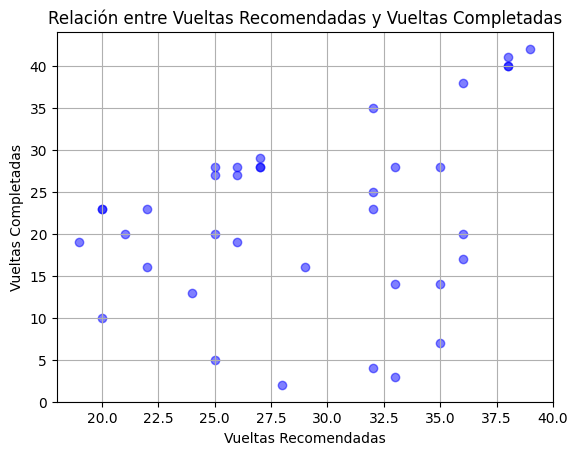

Correlación entre vueltas recomendadas y vueltas completadas con el mismo neumático, obviando Light Rain: 0.33178223018753317


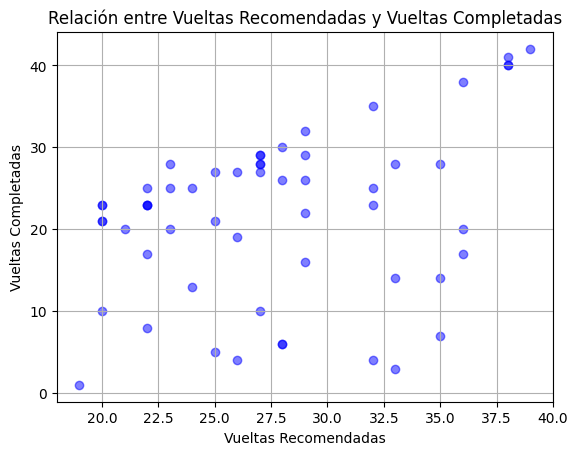

Correlación entre vueltas recomendadas y vueltas completadas con el mismo neumático, obviando lluvia: 0.342453313366008


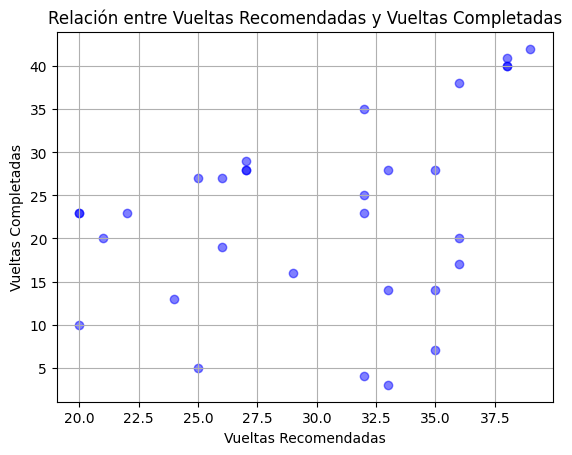

In [188]:
filtered_heavyRain_df = df_chrases[df_chrases['Rain'] != 'Heavy Rain']
correlation = filtered_heavyRain_df['Recommended laps'].corr(filtered_heavyRain_df['Compound laps completed'])
print("Correlación entre vueltas recomendadas y vueltas completadas con el mismo neumático, obviando Heavy Rain:", correlation)
plt.scatter(filtered_heavyRain_df['Recommended laps'], filtered_heavyRain_df['Compound laps completed'], alpha=0.5, color='blue')
plt.title('Relación entre Vueltas Recomendadas y Vueltas Completadas')
plt.xlabel('Vueltas Recomendadas')
plt.ylabel('Vueltas Completadas')
plt.grid(True)
plt.show()

filtered_lightRain_df = df_chrases[df_chrases['Rain'] != 'Light Rain']
correlation = filtered_lightRain_df['Recommended laps'].corr(filtered_lightRain_df['Compound laps completed'])
print("Correlación entre vueltas recomendadas y vueltas completadas con el mismo neumático, obviando Light Rain:", correlation)
plt.scatter(filtered_lightRain_df['Recommended laps'], filtered_lightRain_df['Compound laps completed'], alpha=0.5, color='blue')
plt.title('Relación entre Vueltas Recomendadas y Vueltas Completadas')
plt.xlabel('Vueltas Recomendadas')
plt.ylabel('Vueltas Completadas')
plt.grid(True)
plt.show()

filtered_df = filtered_lightRain_df[filtered_lightRain_df['Rain'] != 'Heavy Rain']
correlation = filtered_df['Recommended laps'].corr(filtered_df['Compound laps completed'])
print("Correlación entre vueltas recomendadas y vueltas completadas con el mismo neumático, obviando lluvia:", correlation)
plt.scatter(filtered_df['Recommended laps'], filtered_df['Compound laps completed'], alpha=0.5, color='blue')
plt.title('Relación entre Vueltas Recomendadas y Vueltas Completadas')
plt.xlabel('Vueltas Recomendadas')
plt.ylabel('Vueltas Completadas')
plt.grid(True)
plt.show()

### Cómo afecta la  temperatura en pista al número de accidentes

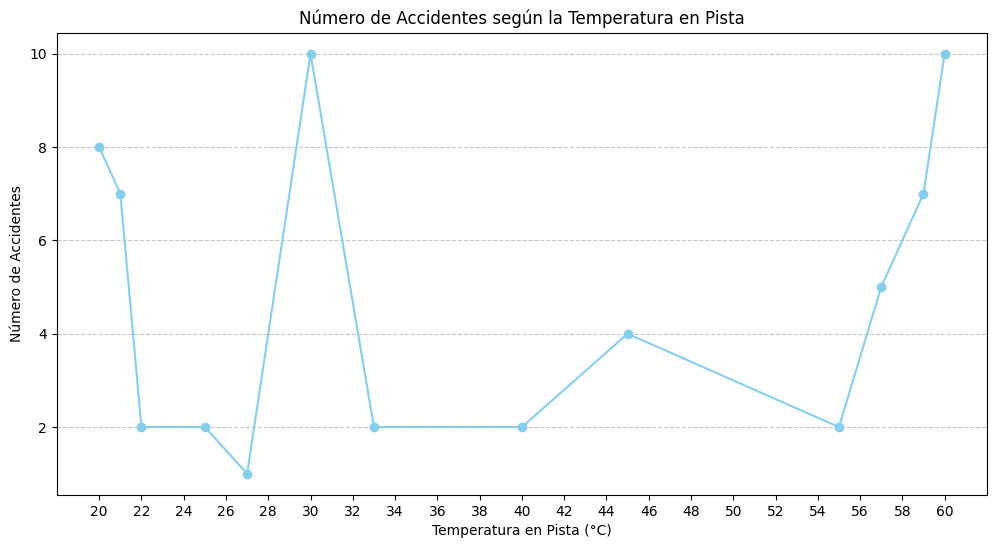

In [189]:
accidents_by_temp = df_chrases.groupby('Temperature')['Lap'].count()

plt.figure(figsize=(12, 6))
accidents_by_temp.plot(marker='o', color='skyblue')
plt.title('Número de Accidentes según la Temperatura en Pista')
plt.xlabel('Temperatura en Pista (°C)')
plt.ylabel('Número de Accidentes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Ajustar los ticks del eje x para mostrar todos los valores
plt.xticks(range(20, 61, 2))  
plt.show()

Si bien es cierto que la gráfica anterior es bastante aleatoria, si podemos observar que se repite un patrón de una acumulación de accidentes tanto en los 30ºC y 20ºC, como en las temperaturas más altas.  
- Para explicar el mayor número de accidentes, nos vale con recordar que justo para 30ºC existen 3 circuitos diferentes (Mónaco, Gilles Villenueve y Australia), teniendo estos dos primeros además una alta probabilidad de lluvia. Y para los 20ºC es similar, son dos circuitos que comparten esa temperatura y siendo uno de ellos Spa, que tiene una probabilidad de 0.8 de lluvia (la más alta del campeonato). Por último, para las temperaturas más altas, en el caso de los 60ºC, se vuelven a repetir dos circuitos con esa misma temperatura. Y aunque no tengas estos una probabilidad de lluvia alta, cabe recalcar que la propia temperatura alta (a partir de los 40ºC) aumenta a su vez la probabilidad de accidente.

## Conclusiones

Tras todo lo visto podemos concluir con bastante certeza que las estrategias que mejor resultan son las más **conservadoras**. Esto quiere decir, parar aproximadamente cuando el neumático llega a sus vueltas recomendadas sin posponerlo mucho, pero tampoco arriesgándose y parando antes para poder hacer mejores tiempos de vuelta (por el propio tiempo de parada añadido). Parando a poner neumáticos de lluvia cuando corresponde y así evitando un accidente que es el mayor "castigo" para un campeonato así.